# 1. Prepare the Data

## 1.1. Load and merge

In [1]:
import pandas as pd
import numpy as np

# ---------- 1.1.1 Load the data ----------
orders      = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products    = pd.read_csv("olist_products_dataset.csv")
customers   = pd.read_csv("olist_customers_dataset.csv")

# ---------- 1.1.2. Process datetime ----------
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"], errors="coerce"
)
orders = orders.dropna(subset=["order_purchase_timestamp"])

# ---------- 1.1.3. Filter out invalid orders (canceled / unavailable) ----------
invalid_status = ["canceled", "unavailable"]
orders_valid = orders[~orders["order_status"].isin(invalid_status)].copy()

# ---------- 1.1.4. Select the required columns ----------
orders_small = orders_valid[[
    "order_id", "customer_id", "order_purchase_timestamp", "order_status"
]]

order_items_small = order_items[[
    "order_id", "product_id", "order_item_id", "price", "freight_value"
]]

products_small = products[[
    "product_id", "product_category_name"
]]

customers_small = customers[[
    "customer_id", "customer_city", "customer_state"
]]

# ---------- 1.1.5. Merge ----------
df = order_items_small.merge(orders_small, on="order_id", how="inner")
df = df.merge(products_small, on="product_id", how="left")
df = df.merge(customers_small, on="customer_id", how="left")

# ---------- 1.1.6. Perform basic cleaning ----------
df["product_category_name"] = df["product_category_name"].fillna("unknown")

# Use floor("D") to keep the date as a datetime object (instead of converting it to a plain date)
df["order_date"] = df["order_purchase_timestamp"].dt.floor("D")

# ---------- 1.1.7. Remove data before 2017 (the structure in 2016 is unreliable) ----------
df = df[df["order_date"] >= pd.to_datetime("2017-01-01")].copy()

# check
print(df[["order_date"]].agg(["min", "max"]))
print("Rows after filtering:", len(df))
df.head()


    order_date
min 2017-01-05
max 2018-09-03
Rows after filtering: 111753


,order_id,product_id,order_item_id,price,freight_value,customer_id,order_purchase_timestamp,order_status,product_category_name,customer_city,customer_state,order_date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,delivered,cool_stuff,campos dos goytacazes,RJ,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,delivered,pet_shop,santa fe do sul,SP,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,delivered,moveis_decoracao,para de minas,MG,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,delivered,perfumaria,atibaia,SP,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,delivered,ferramentas_jardim,varzea paulista,SP,2017-02-04


## 1.2. Prepare the 4 time-sereis

In [2]:
# ---------- 1.2.1 Overall Demand ----------
overall_demand_ts = (
    df.groupby("order_date")["order_item_id"]
      .count()
      .reset_index()
      .rename(columns={"order_item_id": "demand"})
)

# ---------- 1.2.2 Overall GMV (GMV：sum(price)) ----------
overall_gmv_ts = (
    df.groupby("order_date")["price"]
      .sum()
      .reset_index()
      .rename(columns={"price": "gmv"})
)

# ---------- 1.2.3 São Paulo Demand ----------
sp_df = df[df["customer_state"] == "SP"].copy()

sp_demand_ts = (
    sp_df.groupby("order_date")["order_item_id"]
         .count()
         .reset_index()
         .rename(columns={"order_item_id": "demand"})
)

# ---------- 1.2.4 São Paulo GMV ----------
sp_gmv_ts = (
    sp_df.groupby("order_date")["price"]
         .sum()
         .reset_index()
         .rename(columns={"price": "gmv"})
)

# ---------- 1.2.5 Check ----------
print("Overall Demand:", overall_demand_ts.shape)
print("Overall GMV:", overall_gmv_ts.shape)
print("SP Demand:", sp_demand_ts.shape)
print("SP GMV:", sp_gmv_ts.shape)

overall_demand_ts.head()


Overall Demand: (603, 2)
Overall GMV: (603, 2)
SP Demand: (603, 2)
SP GMV: (603, 2)


,order_date,demand
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,6


Ensure series cover a full, continuous date range and fill any missing dates with a zero value

In [3]:
# Create a complete date range (from the earliest to the latest)
full_range = pd.date_range(
    start=df["order_date"].min(),
    end=df["order_date"].max(),
    freq="D"
)

def ensure_full_range(ts_df, value_col):
    ts = ts_df.set_index("order_date").reindex(full_range)
    ts = ts.fillna(0).rename_axis("order_date").reset_index()
    ts = ts.rename(columns={"index": "order_date", value_col: value_col})
    return ts

overall_demand_ts = ensure_full_range(overall_demand_ts, "demand")
overall_gmv_ts    = ensure_full_range(overall_gmv_ts, "gmv")
sp_demand_ts      = ensure_full_range(sp_demand_ts, "demand")
sp_gmv_ts         = ensure_full_range(sp_gmv_ts, "gmv")


# 2. EDA

## 2.1. Trend plots

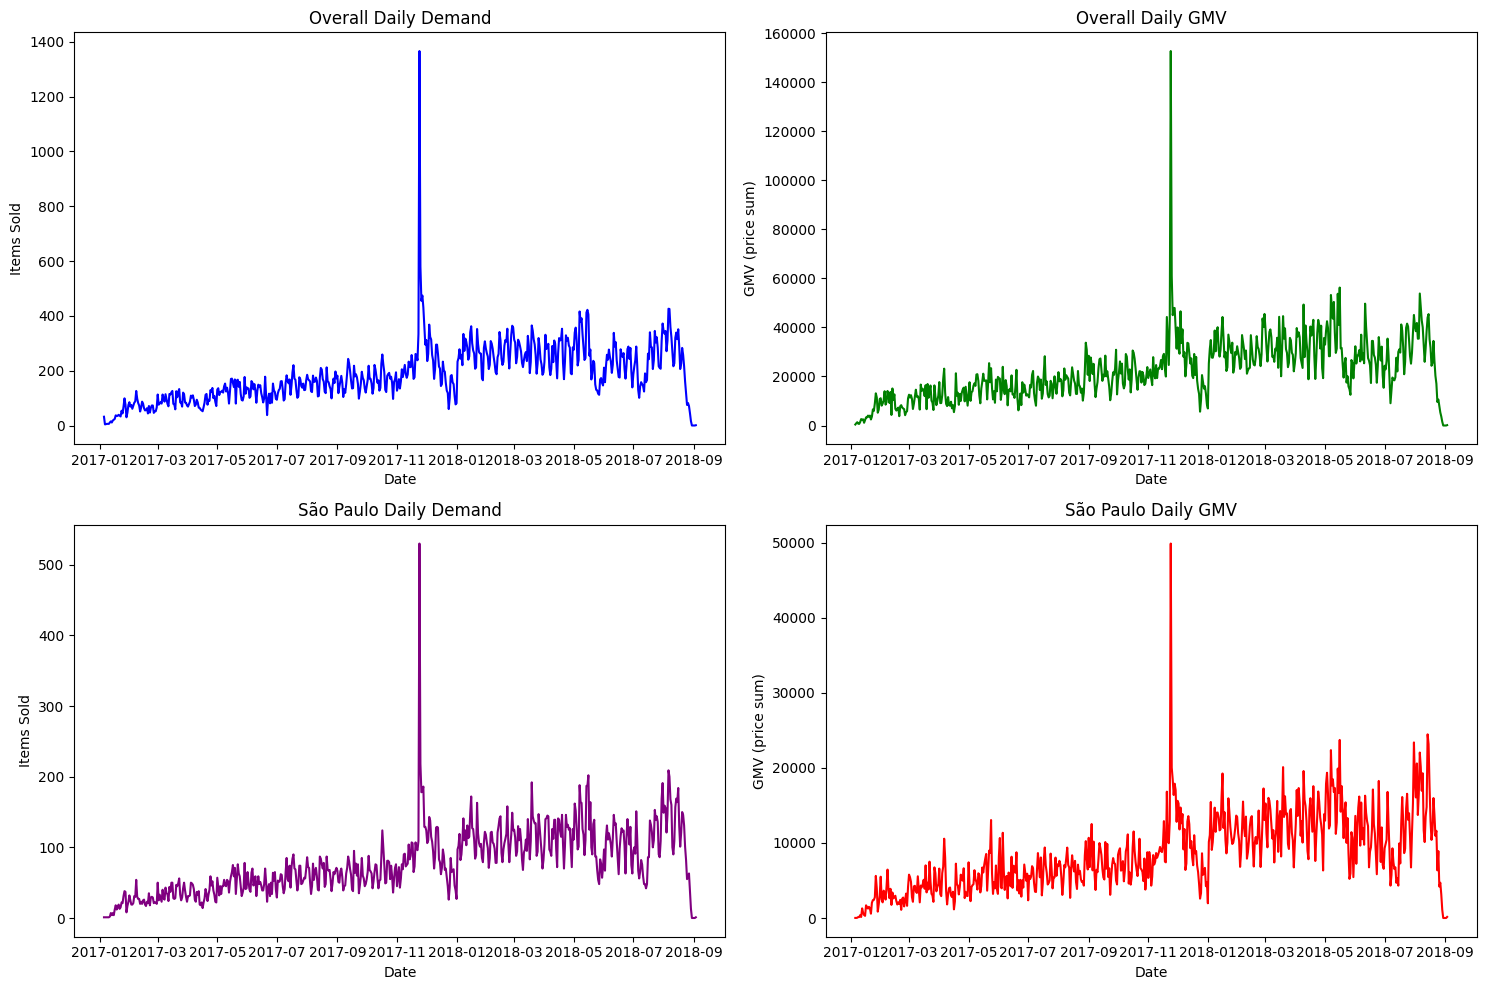

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# ---- Overall Demand ----
plt.subplot(2, 2, 1)
plt.plot(overall_demand_ts["order_date"], overall_demand_ts["demand"], color="blue")
plt.title("Overall Daily Demand")
plt.xlabel("Date")
plt.ylabel("Items Sold")

# ---- Overall GMV ----
plt.subplot(2, 2, 2)
plt.plot(overall_gmv_ts["order_date"], overall_gmv_ts["gmv"], color="green")
plt.title("Overall Daily GMV")
plt.xlabel("Date")
plt.ylabel("GMV (price sum)")

# ---- SP Demand ----
plt.subplot(2, 2, 3)
plt.plot(sp_demand_ts["order_date"], sp_demand_ts["demand"], color="purple")
plt.title("São Paulo Daily Demand")
plt.xlabel("Date")
plt.ylabel("Items Sold")

# ---- SP GMV ----
plt.subplot(2, 2, 4)
plt.plot(sp_gmv_ts["order_date"], sp_gmv_ts["gmv"], color="red")
plt.title("São Paulo Daily GMV")
plt.xlabel("Date")
plt.ylabel("GMV (price sum)")

plt.tight_layout()
plt.show()


## 2.2. STL decomposition

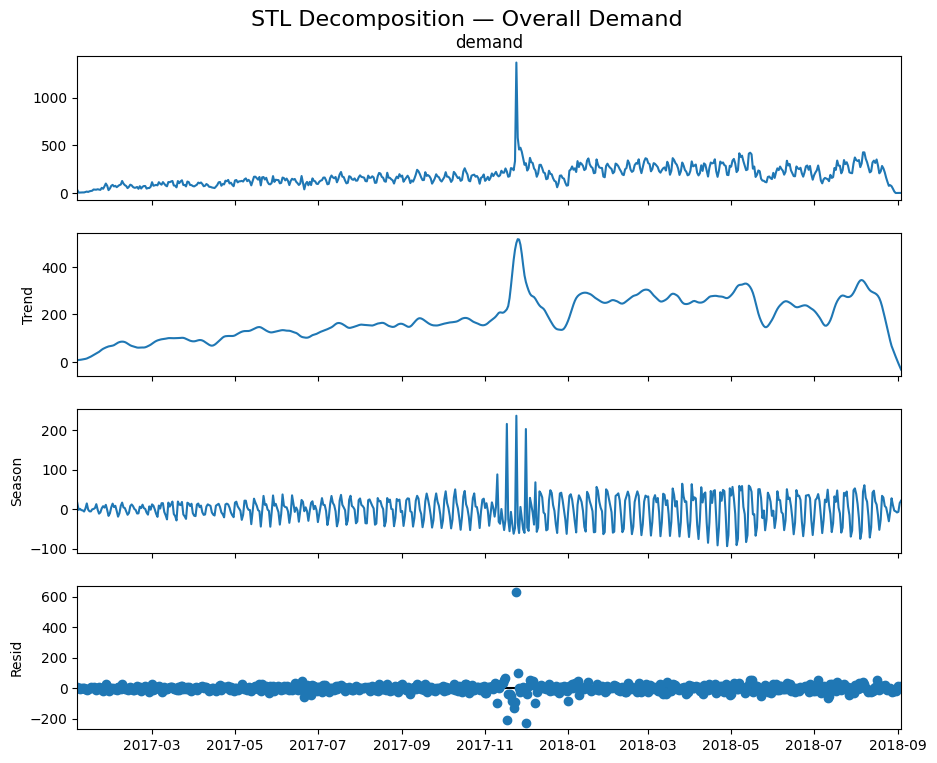

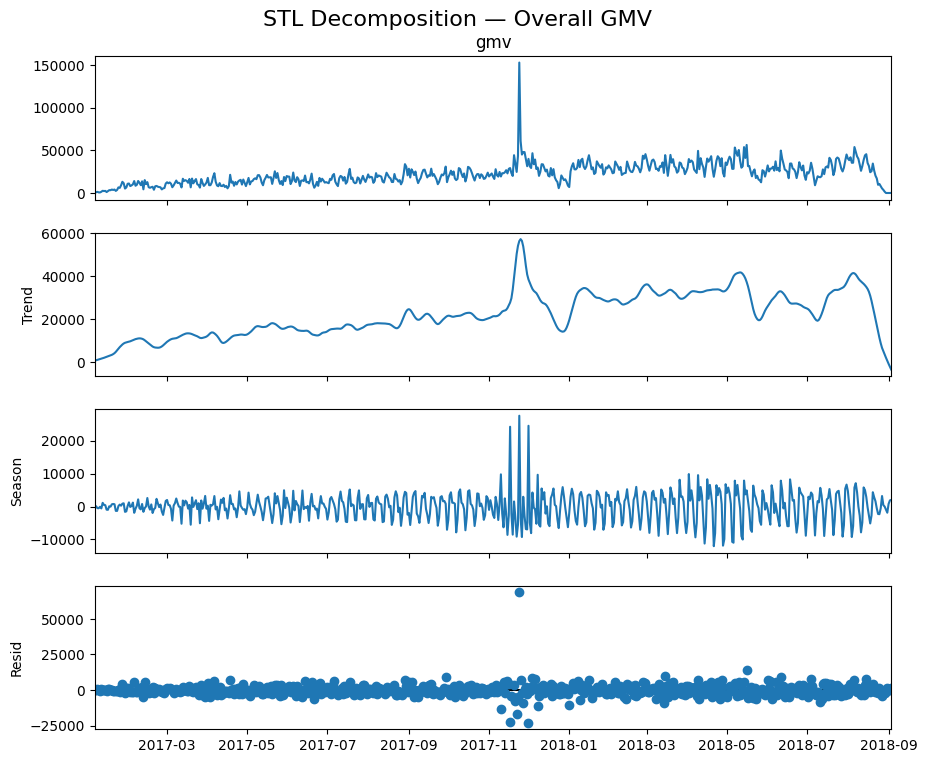

In [5]:
from statsmodels.tsa.seasonal import STL

# ---- helper function ----
def plot_stl(ts_df, value_col, title):
    ts_df = ts_df.set_index("order_date")
    stl = STL(ts_df[value_col], period=7).fit()   # 7-day seasonality (weekly)
    fig = stl.plot()
    fig.set_size_inches(10, 8)
    fig.suptitle(title, fontsize=16)
    plt.show()

# ---- Overall Demand STL ----
plot_stl(overall_demand_ts, "demand", "STL Decomposition — Overall Demand")

# ---- Overall GMV STL ----
plot_stl(overall_gmv_ts, "gmv", "STL Decomposition — Overall GMV")


# 3. Models

## 3.1. Baseline - linear regression

### 3.1.1. Baseline construction and performance

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

# Linear trend baseline evaluation for four series:
# overall_demand_ts, overall_gmv_ts, sp_demand_ts, sp_gmv_ts

def eval_linear_trend(ts_df, value_col, name, test_frac=0.2):
    ts = ts_df.sort_values("order_date").copy()
    # feature: days since start (integer)
    days = (ts["order_date"] - ts["order_date"].min()).dt.days.values.reshape(-1, 1)
    y = ts[value_col].values.astype(float)

    n = len(y)
    if n < 10:
        raise ValueError(f"Series {name} too short ({n} rows) for reliable train/test split")

    split = int(np.floor(n * (1 - test_frac)))
    X_train, X_test = days[:split], days[split:]
    y_train, y_test = y[:split], y[split:]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # MAE
    mae = mean_absolute_error(y_test, y_pred_test)

    # OSR2: 1 - SSE_model / SSE_benchmark where benchmark = train mean
    sse_model = np.sum((y_test - y_pred_test) ** 2)
    sse_bench = np.sum((y_test - y_train.mean()) ** 2)
    osr2 = 1.0 - sse_model / sse_bench if sse_bench > 0 else np.nan

    return {"series": name, "n_train": len(y_train), "n_test": len(y_test), "OSR2": osr2, "MAE": mae, "model_coef": model.coef_[0], "model_intercept": model.intercept_}

# Evaluate the four series
results = []
results.append(eval_linear_trend(overall_demand_ts, "demand", "Overall Demand"))
results.append(eval_linear_trend(overall_gmv_ts, "gmv", "Overall GMV"))
results.append(eval_linear_trend(sp_demand_ts, "demand", "SP Demand"))
results.append(eval_linear_trend(sp_gmv_ts, "gmv", "SP GMV"))

# Print a concise summary
for r in results:
    print(f"{r['series']}: OSR2 = {r['OSR2']:.4f}, MAE = {r['MAE']:.4f} (train={r['n_train']}, test={r['n_test']})")

Overall Demand: OSR2 = -0.7132, MAE = 117.7460 (train=485, test=122)
Overall GMV: OSR2 = -0.4275, MAE = 13485.0810 (train=485, test=122)
SP Demand: OSR2 = 0.0390, MAE = 44.5785 (train=485, test=122)
SP GMV: OSR2 = 0.0408, MAE = 5195.5842 (train=485, test=122)


### 3.1.2. Baseline plots

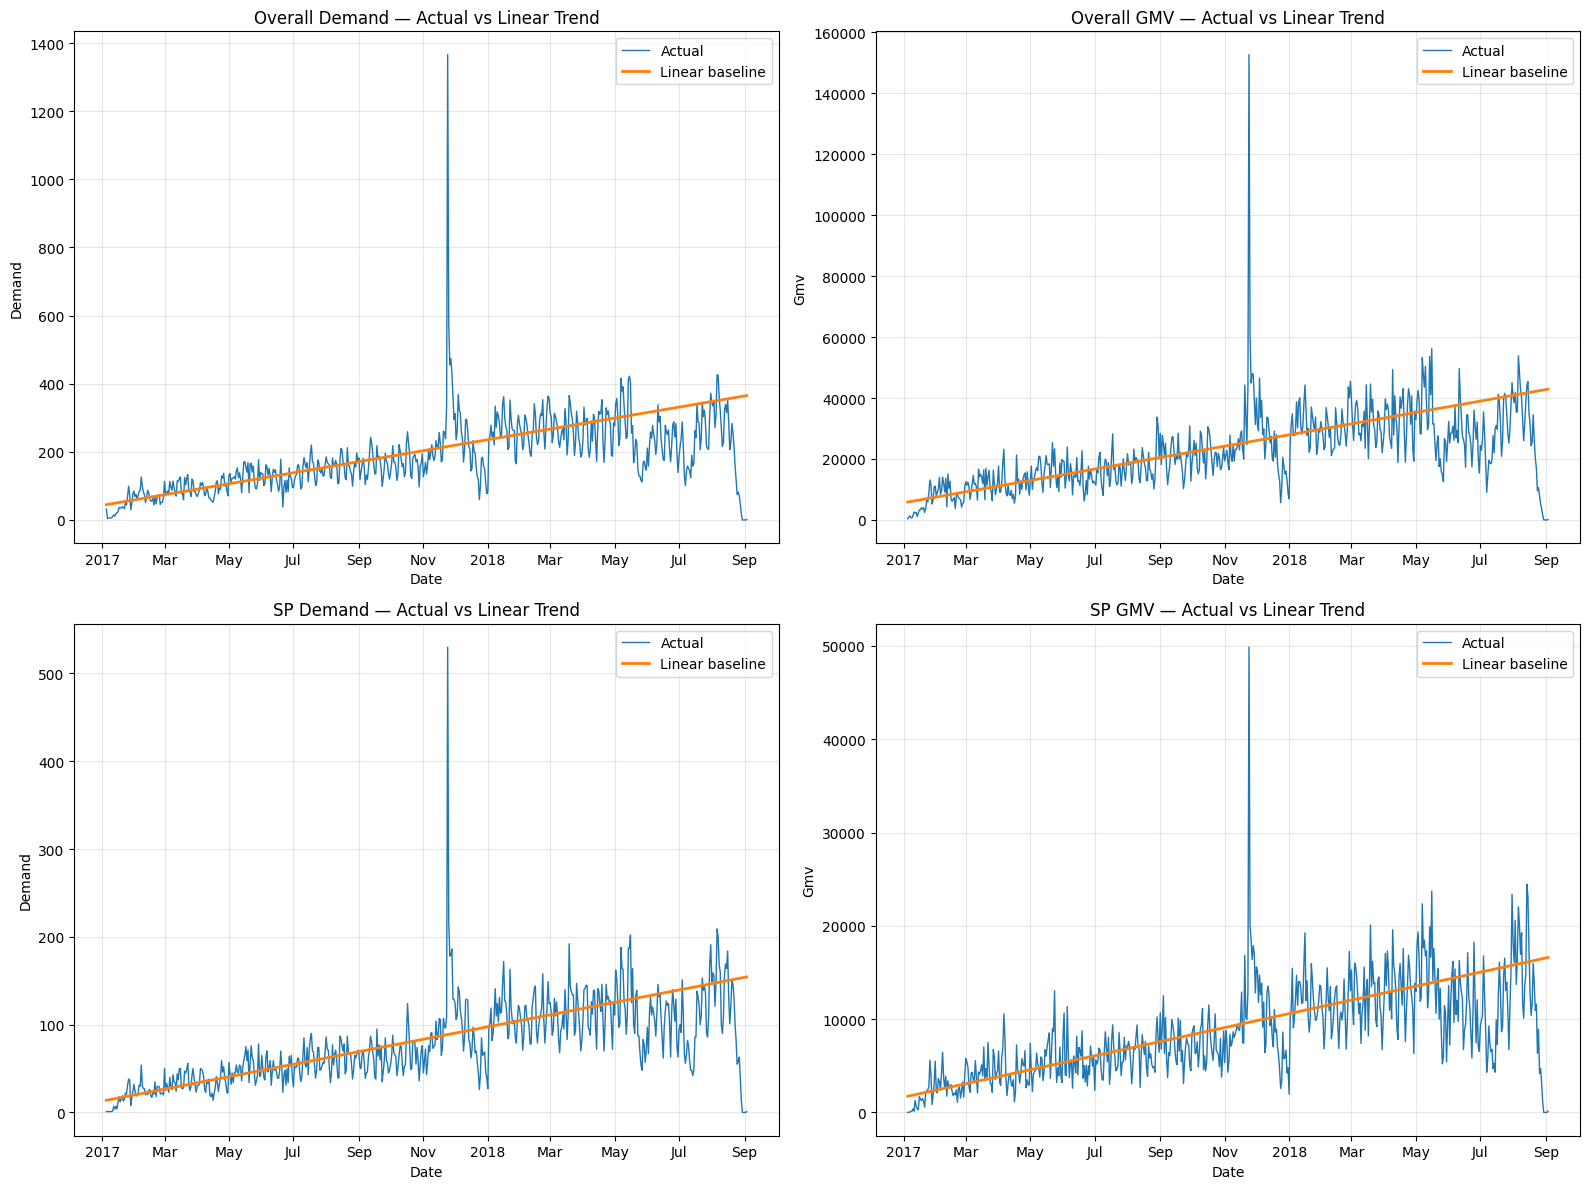

In [7]:
# Plot linear-trend baseline vs real data for the four series
import matplotlib.dates as mdates

# Build a lookup for coefficients/intercepts from `results`
res_map = {r["series"]: r for r in results}

series_info = [
    (overall_demand_ts, "demand", "Overall Demand"),
    (overall_gmv_ts, "gmv", "Overall GMV"),
    (sp_demand_ts, "demand", "SP Demand"),
    (sp_gmv_ts, "gmv", "SP GMV"),
]

plt.figure(figsize=(16, 12))
for i, (ts_df, col, name) in enumerate(series_info, 1):
    ax = plt.subplot(2, 2, i)
    ts = ts_df.sort_values("order_date").copy()
    dates = ts["order_date"]
    days = (dates - dates.min()).dt.days.values  # integer days since start

    # get model params
    coef = float(res_map[name]["model_coef"])
    intercept = float(res_map[name]["model_intercept"])

    y_true = ts[col].values.astype(float)
    y_pred = coef * days + intercept

    ax.plot(dates, y_true, label="Actual", color="#1f77b4", linewidth=1)
    ax.plot(dates, y_pred, label="Linear baseline", color="#ff7f0e", linewidth=2)

    ax.set_title(f"{name} — Actual vs Linear Trend")
    ax.set_xlabel("Date")
    ax.set_ylabel(col.capitalize())
    ax.legend()
    ax.grid(alpha=0.3)

    # nicer x-axis formatting
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.tight_layout()
plt.show()

## 3.2. SARIMA

### 3.2.1. ACF, PACF, ADF test

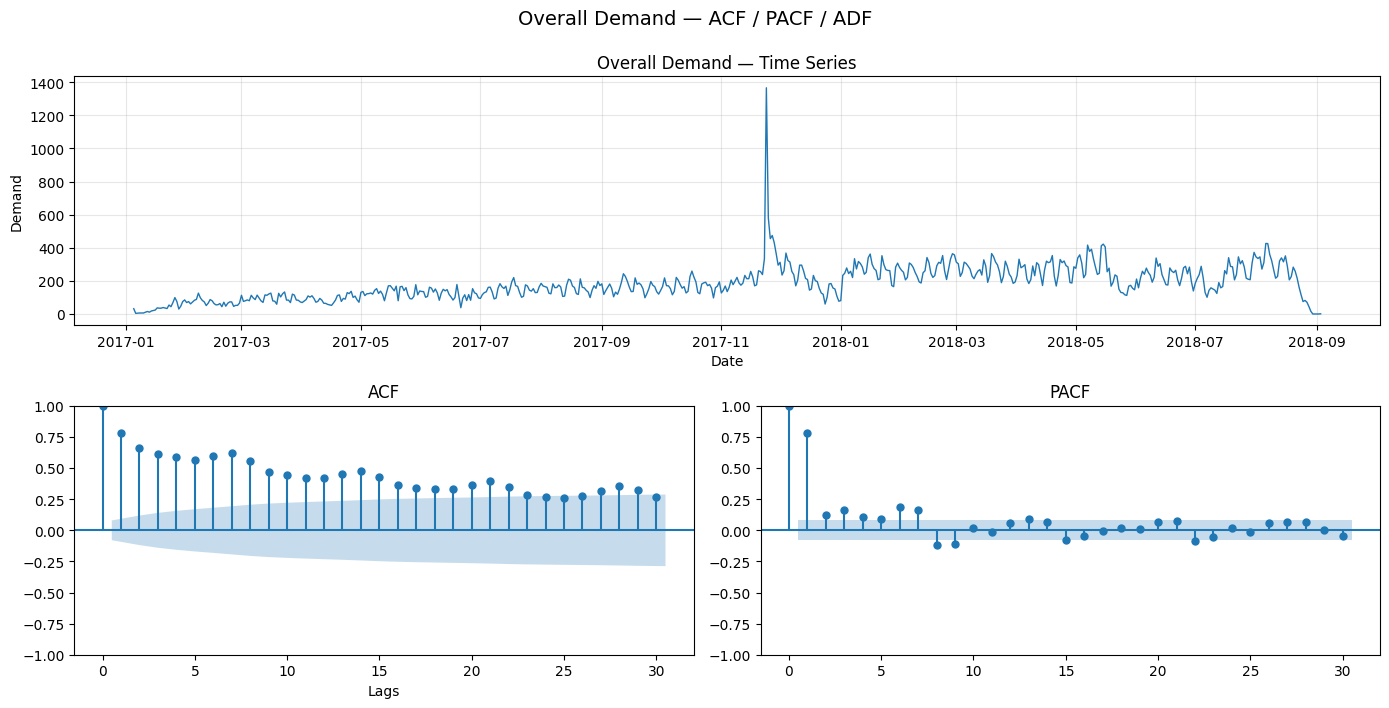


ADF test — Overall Demand
  Test Statistic : -2.9705
  p-value        : 3.7745e-02
  Usedlag        : 14
  Number of obs  : 592
  Critical Values:
    1%: -3.4414
    5%: -2.8664
    10%: -2.5694
  Stationary at 5%? YES



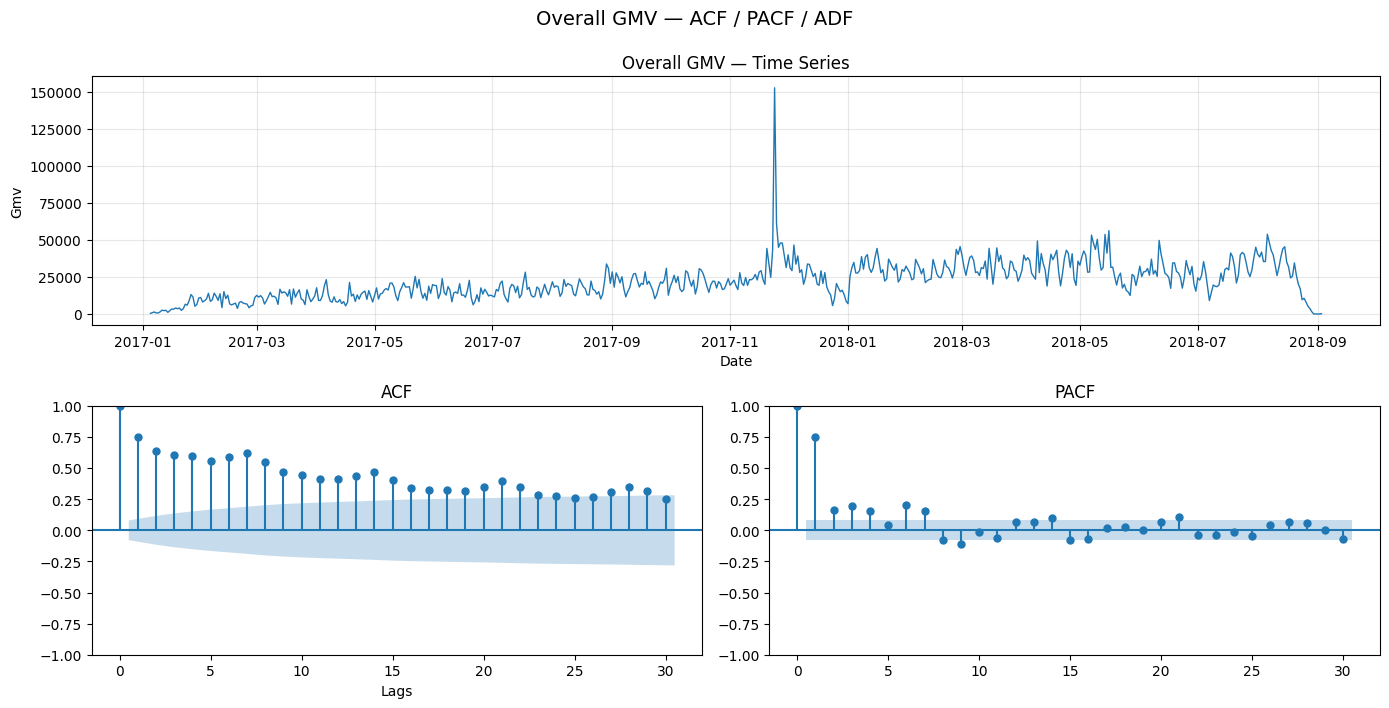


ADF test — Overall GMV
  Test Statistic : -3.1700
  p-value        : 2.1790e-02
  Usedlag        : 15
  Number of obs  : 591
  Critical Values:
    1%: -3.4415
    5%: -2.8664
    10%: -2.5694
  Stationary at 5%? YES



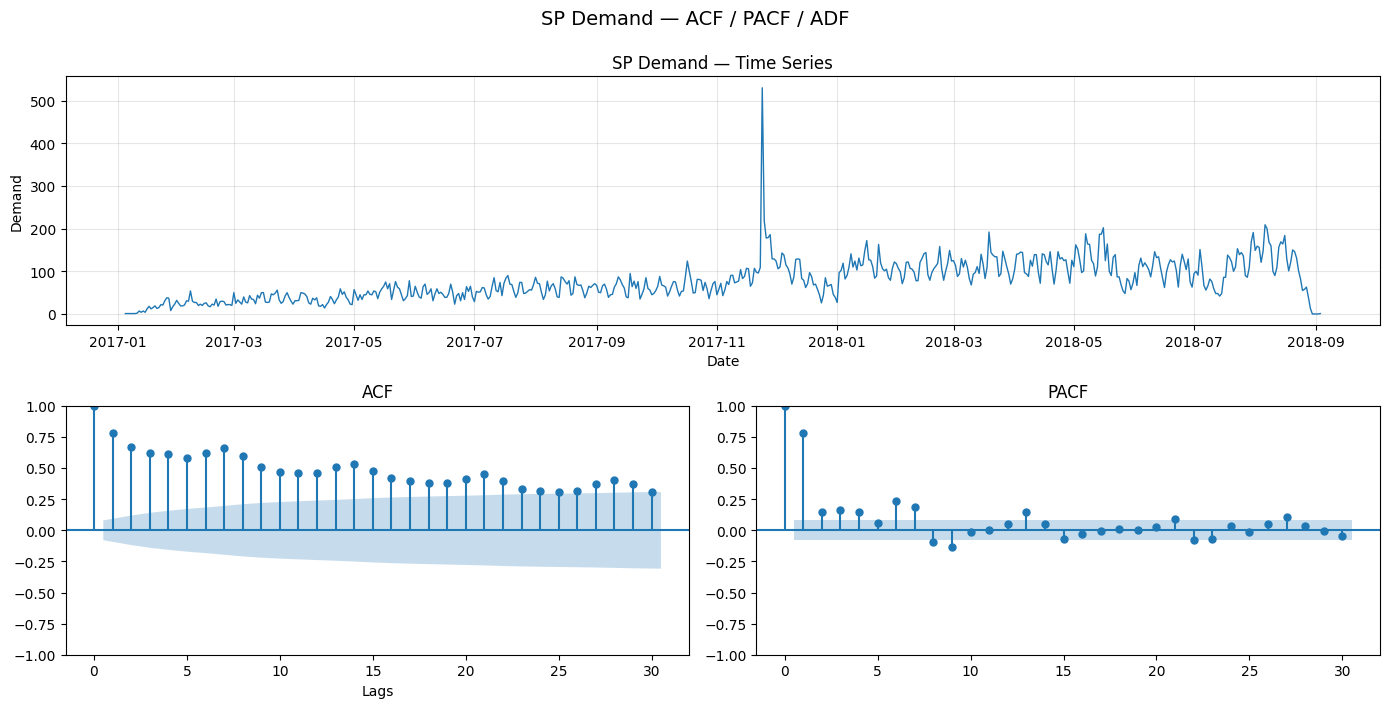


ADF test — SP Demand
  Test Statistic : -2.7927
  p-value        : 5.9319e-02
  Usedlag        : 14
  Number of obs  : 592
  Critical Values:
    1%: -3.4414
    5%: -2.8664
    10%: -2.5694
  Stationary at 5%? NO



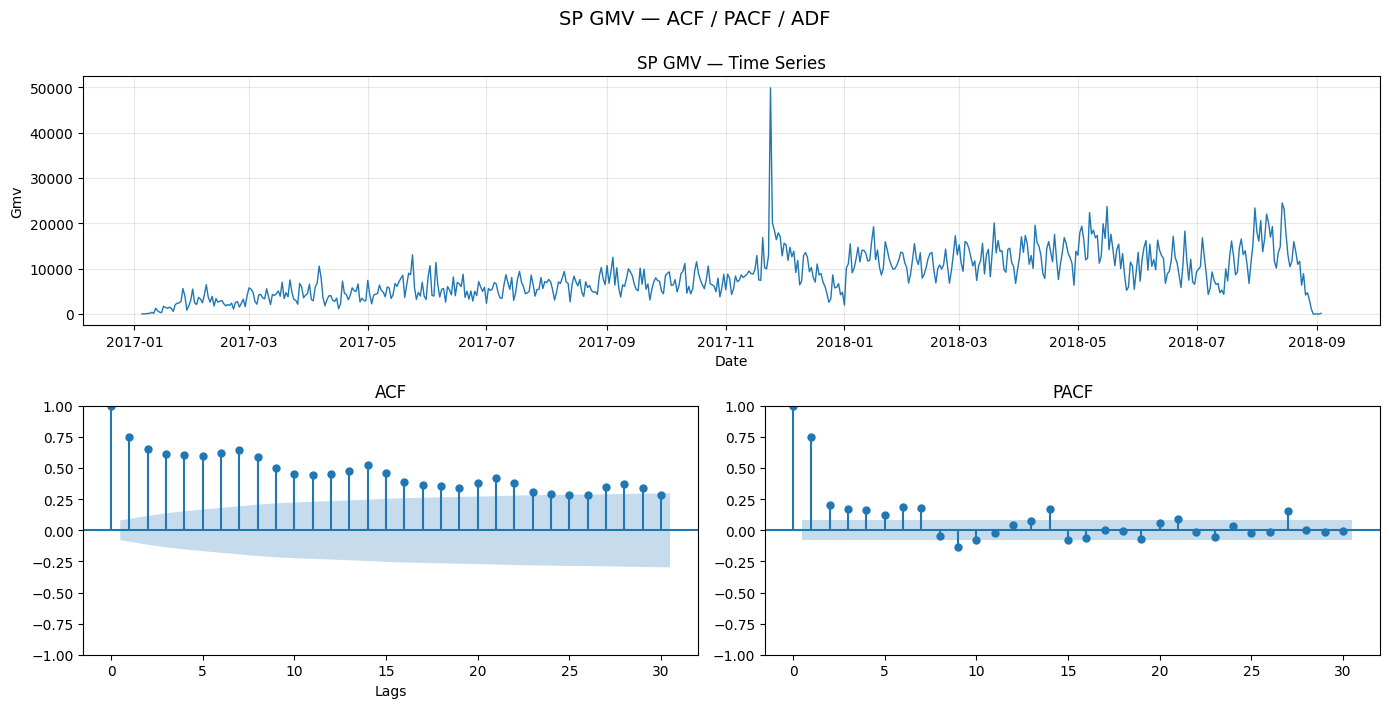


ADF test — SP GMV
  Test Statistic : -2.9537
  p-value        : 3.9449e-02
  Usedlag        : 15
  Number of obs  : 591
  Critical Values:
    1%: -3.4415
    5%: -2.8664
    10%: -2.5694
  Stationary at 5%? YES



In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def analyze_ts(ts_df, value_col, name, nlags=30):
    """
    Plot time series, ACF, PACF and run ADF test.
    Assumes ts_df has a datetime column 'order_date'.
    """
    ts = ts_df.sort_values("order_date").copy()
    series = ts[value_col].astype(float).dropna().reset_index(drop=True)

    # Time series plot
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(ts["order_date"], ts[value_col], color="#1f77b4", linewidth=1)
    plt.title(f"{name} — Time Series")
    plt.xlabel("Date")
    plt.ylabel(value_col.capitalize())
    plt.grid(alpha=0.3)

    # ACF
    plt.subplot(3, 2, 3)
    plot_acf(series, lags=nlags, zero=True, ax=plt.gca(), title="ACF")
    plt.xlabel("Lags")

    # PACF
    plt.subplot(3, 2, 4)
    # use method='ywm' or default depending on statsmodels version
    try:
        plot_pacf(series, lags=nlags, ax=plt.gca(), title="PACF", method="ywm")
    except TypeError:
        plot_pacf(series, lags=nlags, ax=plt.gca(), title="PACF")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"{name} — ACF / PACF / ADF", fontsize=14, y=0.99)
    plt.show()

    # ADF test
    adf_res = adfuller(series.values, autolag="AIC")
    adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = adf_res[0], adf_res[1], adf_res[2], adf_res[3], adf_res[4], adf_res[5]

    print(f"\nADF test — {name}")
    print(f"  Test Statistic : {adf_stat:.4f}")
    print(f"  p-value        : {pvalue:.4e}")
    print(f"  Usedlag        : {usedlag}")
    print(f"  Number of obs  : {nobs}")
    print("  Critical Values:")
    for k, v in crit_vals.items():
        print(f"    {k}: {v:.4f}")
    stationary = "YES" if pvalue < 0.05 else "NO"
    print(f"  Stationary at 5%? {stationary}\n")


# Analyze the four series defined in the notebook.
# Uses variable `series_info` from the notebook (list of tuples: (ts_df, col, name)).
for ts_df, col, name in series_info:
    analyze_ts(ts_df, col, name, nlags=30)

### 3.2.2. SARIMA model construction

An exhaustive grid search to find the optimal $\text{SARIMA}(p, d, q) \times (P, D, Q)_S$ model parameters for the 4 time series, then evaluates and compares the best model's $\text{MAE}$ and $\text{OSR}^2$ against the baseline.

In [9]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import numpy as np

warnings.filterwarnings("ignore")

# Use existing `results` -> build a lookup for baseline metrics
res_map = {r["series"]: r for r in results}

def fit_best_sarima(ts_df, value_col, name, seasonal_period=7, test_frac=0.2,
                    p_range=(0,1,2), d_range=(0,1), q_range=(0,1,2),
                    P_range=(0,1), D_range=(0,1), Q_range=(0,1),
                    maxiter=50):
    ts = ts_df.sort_values("order_date").copy()
    y = ts[value_col].astype(float).values
    n = len(y)
    split = int(np.floor(n * (1 - test_frac)))
    y_train, y_test = y[:split], y[split:]
    n_test = len(y_test)
    if n_test == 0:
        raise ValueError("Test set empty. Reduce test_frac or use longer series.")
    best = {"mae": np.inf}

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                model = SARIMAX(y_train,
                                                order=(p,d,q),
                                                seasonal_order=(P,D,Q,seasonal_period),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                trend='c')
                                fit = model.fit(disp=False, maxiter=maxiter)
                                # Forecast n_test steps ahead
                                pred = fit.get_forecast(steps=n_test).predicted_mean
                                mae = mean_absolute_error(y_test, pred)
                                # OSR2: compare SSE_model vs SSE_bench (train mean)
                                sse_model = np.sum((y_test - pred) ** 2)
                                sse_bench = np.sum((y_test - y_train.mean()) ** 2)
                                osr2 = 1.0 - sse_model / sse_bench if sse_bench > 0 else np.nan

                                # Prefer lower MAE
                                score = mae
                                if score < best["mae"]:
                                    best = {
                                        "order": (p,d,q),
                                        "seasonal_order": (P,D,Q,seasonal_period),
                                        "mae": mae,
                                        "osr2": osr2,
                                        "aic": fit.aic,
                                        "model_fit": fit,
                                        "pred": pred
                                    }
                            except Exception:
                                continue
    # Clean up fit object to avoid large output when printing
    model_fit = best.pop("model_fit", None)
    return best

# Run for the four series in `series_info`
arima_results = []
for ts_df, col, name in series_info:
    print(f"\n=== Searching best SARIMA for: {name} ({col}) ===")
    best = fit_best_sarima(ts_df, col, name,
                           seasonal_period=7,
                           p_range=(0,1,2),
                           d_range=(0,1),
                           q_range=(0,1,2),
                           P_range=(0,1),
                           D_range=(0,1),
                           Q_range=(0,1),
                           maxiter=100)
    if not best:
        print("No converged model found.")
        continue

    baseline = res_map.get(name, {})
    # Report
    print(f"Best SARIMA order={best['order']}, seasonal_order={best['seasonal_order']}")
    print(f"  AIC  : {best['aic']:.1f}")
    print(f"  MAE  : {best['mae']:.3f}")
    print(f"  OSR2 : {best['osr2']:.4f}")

    if baseline:
        print("  Baseline (linear trend):")
        print(f"    MAE  : {baseline['MAE']:.3f}")
        print(f"    OSR2 : {baseline['OSR2']:.4f}")
        mae_impr = baseline['MAE'] - best['mae']
        osr2_diff = best['osr2'] - baseline['OSR2']
        print(f"  Improvement vs baseline -> MAE change: {mae_impr:+.3f}, OSR2 change: {osr2_diff:+.4f}")

    arima_results.append({"series": name, **best})

# Summarize succinctly
print("\n=== Summary of chosen SARIMA models ===")
for r in arima_results:
    print(f"{r['series']}: order={r['order']} seasonal={r['seasonal_order']}  MAE={r['mae']:.3f}  OSR2={r['osr2']:.4f}")


=== Searching best SARIMA for: Overall Demand (demand) ===
Best SARIMA order=(1, 0, 2), seasonal_order=(0, 0, 1, 7)
  AIC  : 5288.9
  MAE  : 75.862
  OSR2 : 0.2846
  Baseline (linear trend):
    MAE  : 117.746
    OSR2 : -0.7132
  Improvement vs baseline -> MAE change: +41.884, OSR2 change: +0.9977

=== Searching best SARIMA for: Overall GMV (gmv) ===
Best SARIMA order=(2, 0, 2), seasonal_order=(1, 0, 1, 7)
  AIC  : 9847.9
  MAE  : 8791.111
  OSR2 : 0.3602
  Baseline (linear trend):
    MAE  : 13485.081
    OSR2 : -0.4275
  Improvement vs baseline -> MAE change: +4693.970, OSR2 change: +0.7877

=== Searching best SARIMA for: SP Demand (demand) ===
Best SARIMA order=(2, 0, 1), seasonal_order=(0, 0, 0, 7)
  AIC  : 4550.9
  MAE  : 35.930
  OSR2 : 0.4194
  Baseline (linear trend):
    MAE  : 44.578
    OSR2 : 0.0390
  Improvement vs baseline -> MAE change: +8.649, OSR2 change: +0.3804

=== Searching best SARIMA for: SP GMV (gmv) ===
Best SARIMA order=(1, 0, 2), seasonal_order=(1, 0, 1, 7)

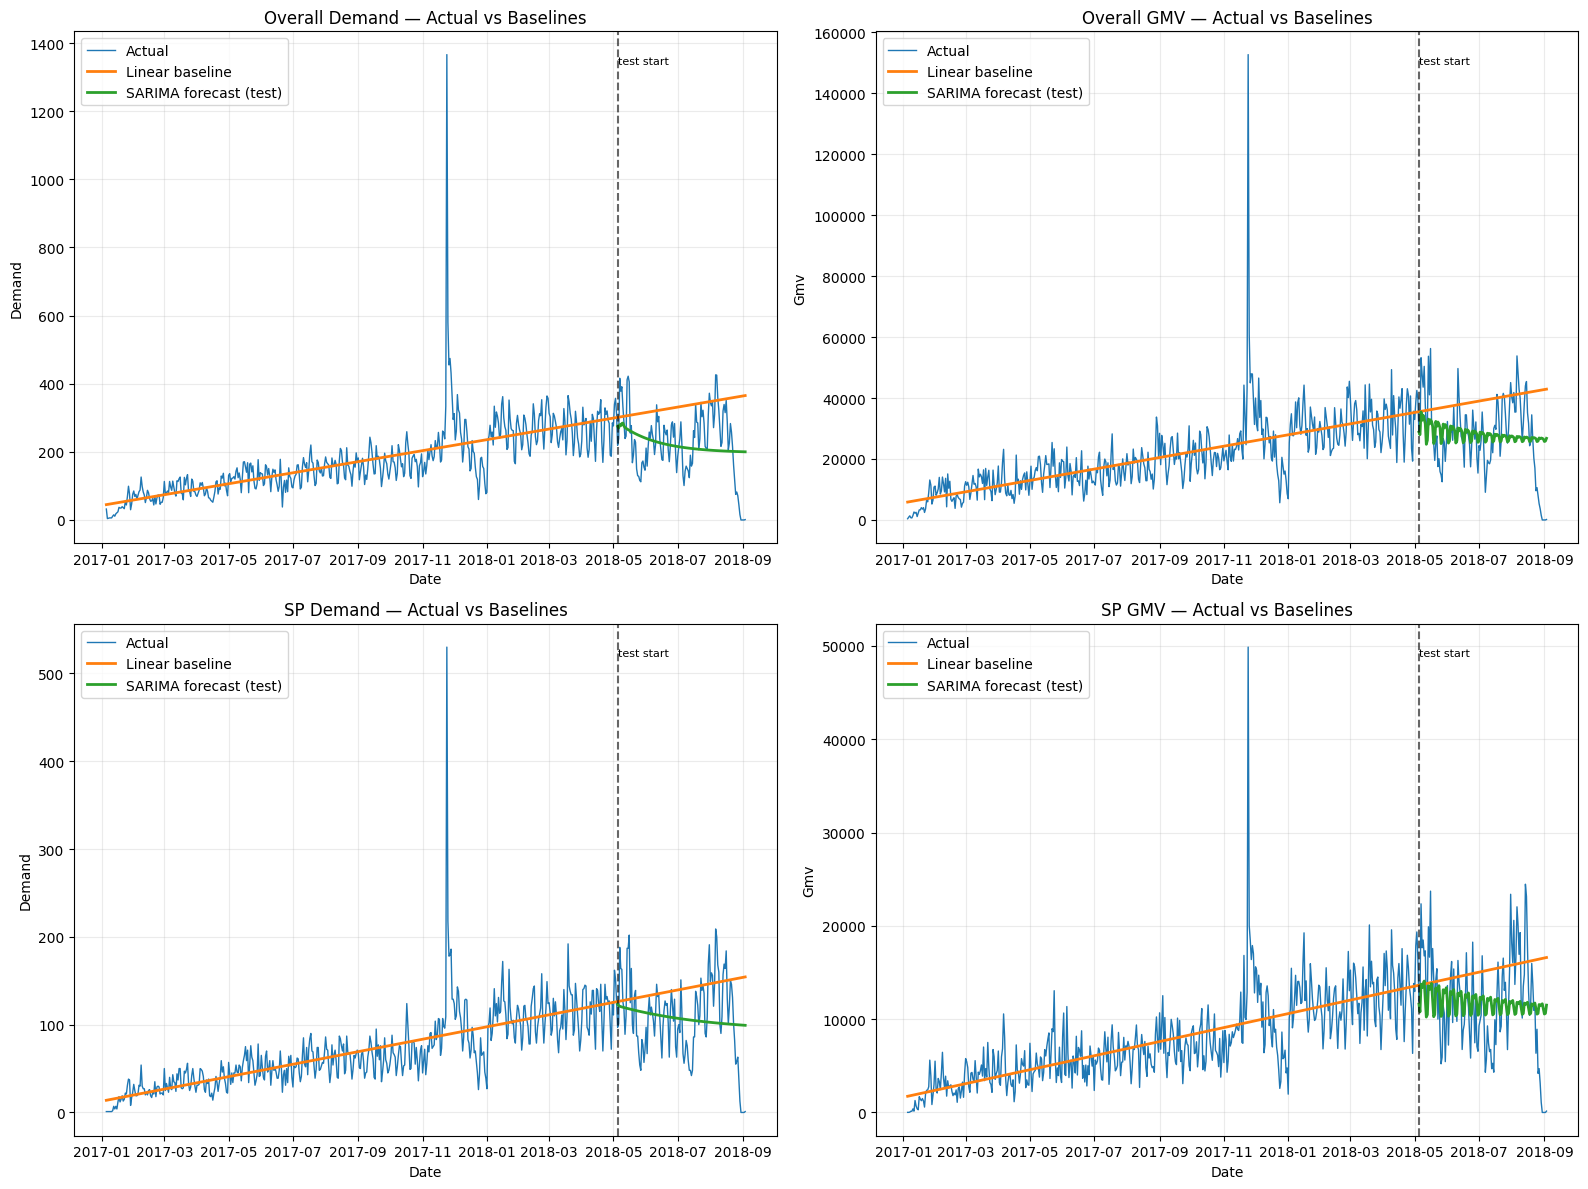

In [10]:
import numpy as np

# Plot Actual vs Linear baseline vs SARIMA predictions (test) for the 4 series

# build lookups from existing notebook variables
res_map = {r["series"]: r for r in results}               # linear baseline info
arima_map = {r["series"]: r for r in arima_results} if "arima_results" in globals() else {}

plt.figure(figsize=(16, 12))
for i, (ts_df, col, name) in enumerate(series_info, 1):
    ax = plt.subplot(2, 2, i)
    ts = ts_df.sort_values("order_date").copy()
    dates = ts["order_date"].reset_index(drop=True)
    y = ts[col].astype(float).values

    # determine split using baseline's n_train (same split used for SARIMA)
    n_train = int(res_map[name]["n_train"])
    split_idx = n_train if n_train < len(y) else int(np.floor(len(y) * 0.8))

    # linear baseline across full range
    days = (dates - dates.min()).dt.days.values
    coef = float(res_map[name]["model_coef"])
    intercept = float(res_map[name]["model_intercept"])
    y_lin = coef * days + intercept

    # plot actual and linear baseline
    ax.plot(dates, y, label="Actual", color="#1f77b4", linewidth=1)
    ax.plot(dates, y_lin, label="Linear baseline", color="#ff7f0e", linewidth=2)

    # overlay SARIMA predictions for test period if available
    ar = arima_map.get(name)
    if ar is not None and "pred" in ar and ar["pred"] is not None:
        pred = np.asarray(ar["pred"]).reshape(-1)
        test_dates = dates.iloc[split_idx : split_idx + len(pred)]
        ax.plot(test_dates, pred, label="SARIMA forecast (test)", color="#2ca02c", linewidth=2)

    # vertical line separating train / test
    if split_idx < len(dates):
        ax.axvline(dates.iloc[split_idx], color="k", linestyle="--", alpha=0.6)
        ax.text(dates.iloc[split_idx], ax.get_ylim()[1]*0.95, "test start", ha="left", va="top", fontsize=8)

    ax.set_title(f"{name} — Actual vs Baselines")
    ax.set_xlabel("Date")
    ax.set_ylabel(col.capitalize())
    ax.legend()
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

### 3.2.3. Diagnostic checks for chosen SARIMA models

Running diagnostics (simplified) for: Overall Demand  order=(1, 0, 2) seasonal=(0, 0, 1, 7)


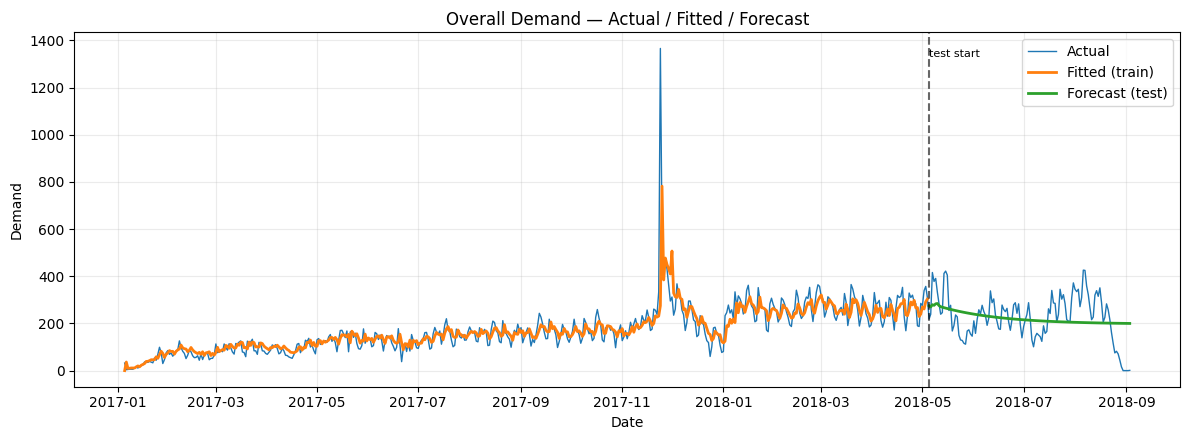

<Figure size 800x350 with 0 Axes>

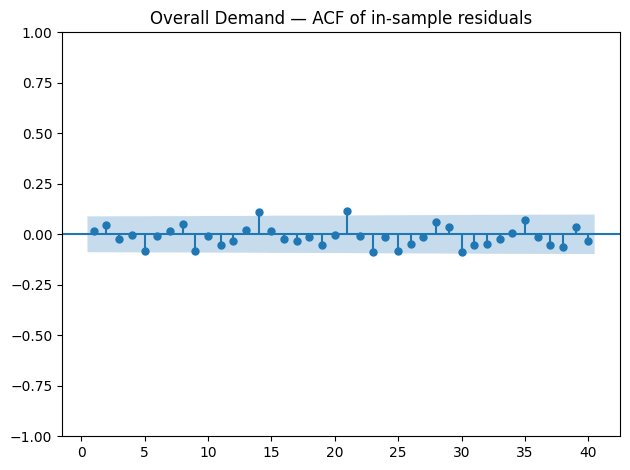

Running diagnostics (simplified) for: Overall GMV  order=(2, 0, 2) seasonal=(1, 0, 1, 7)


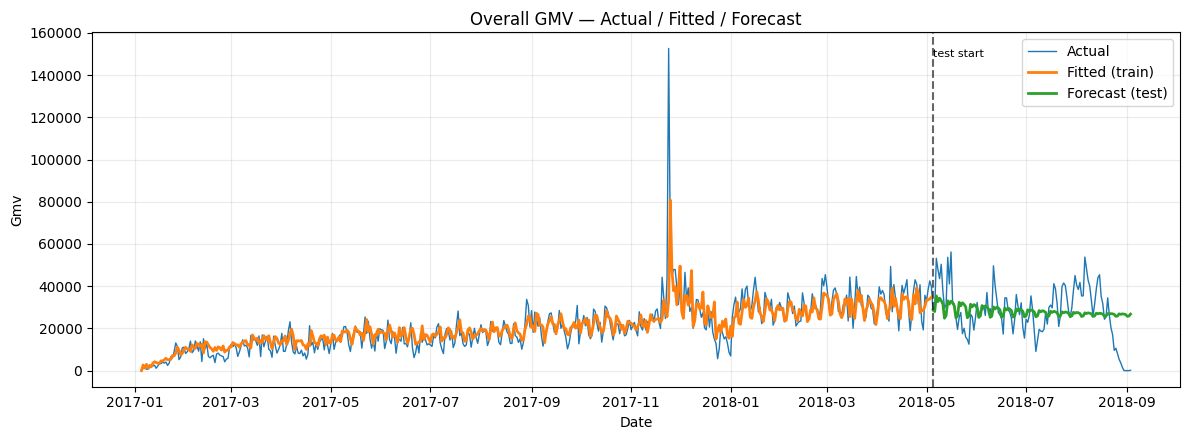

<Figure size 800x350 with 0 Axes>

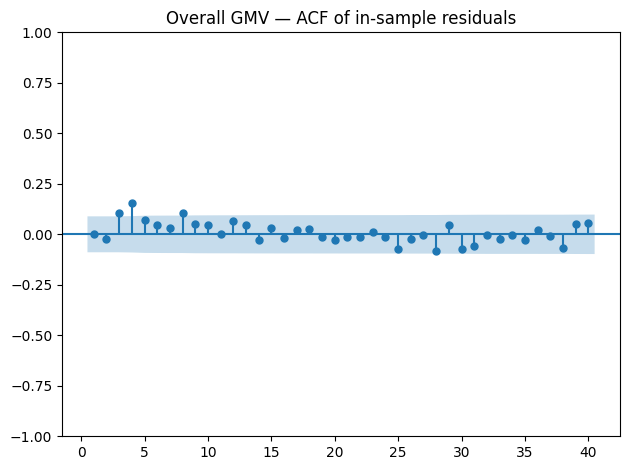

Running diagnostics (simplified) for: SP Demand  order=(2, 0, 1) seasonal=(0, 0, 0, 7)


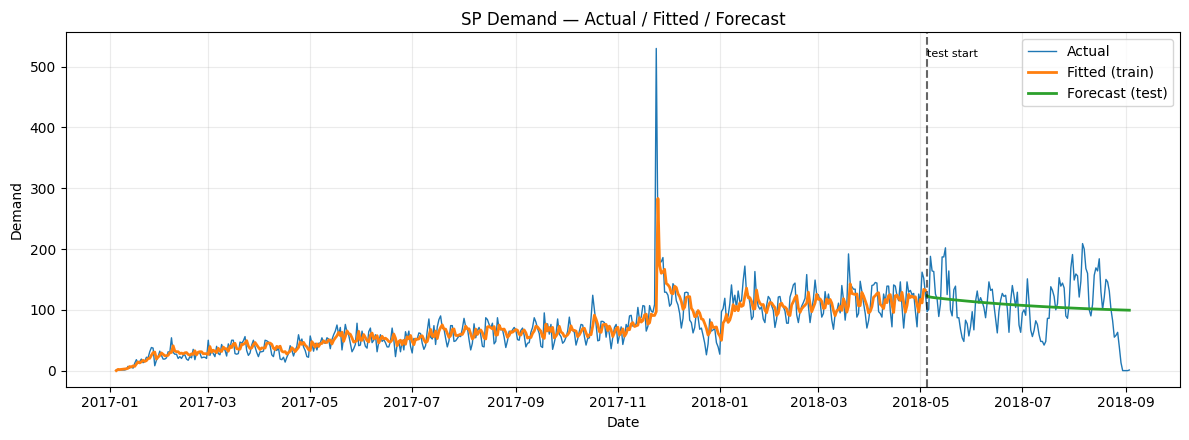

<Figure size 800x350 with 0 Axes>

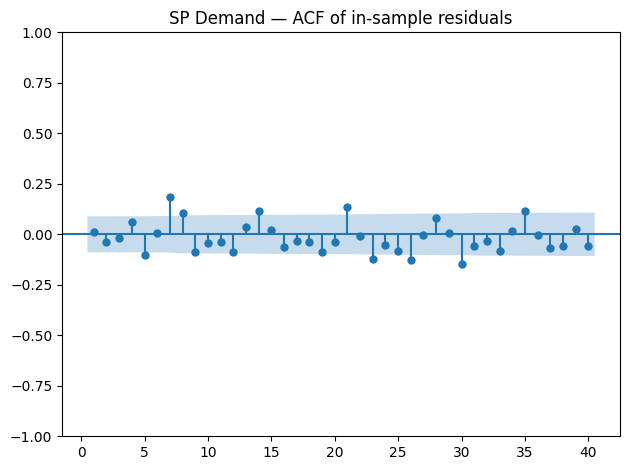

Running diagnostics (simplified) for: SP GMV  order=(1, 0, 2) seasonal=(1, 0, 1, 7)


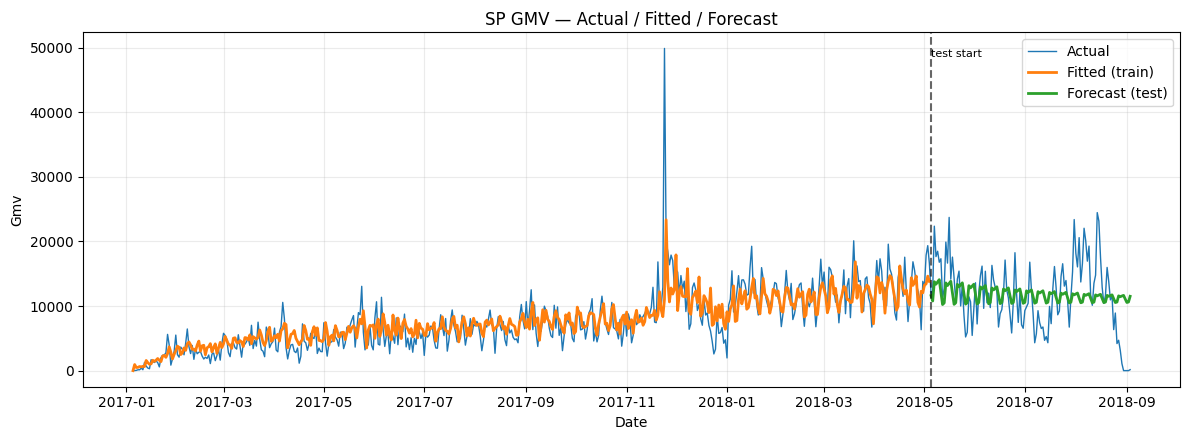

<Figure size 800x350 with 0 Axes>

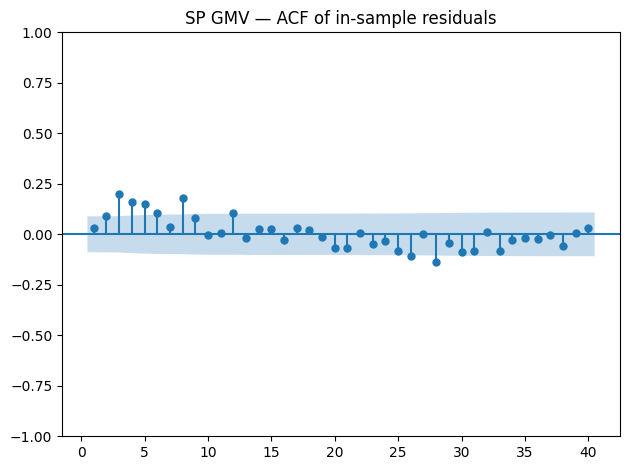

In [11]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

# Require these notebook variables: arima_results, series_info, results
if "arima_results" not in globals() or not arima_results:
    raise RuntimeError("arima_results not found - run the SARIMA search cell first.")

# build lookup for time series by series name
ts_map = {name: (ts_df, col) for ts_df, col, name in series_info}
res_map = {r["series"]: r for r in results} if "results" in globals() else {}

for entry in arima_results:
    name = entry["series"]
    order = tuple(entry["order"])
    seasonal = tuple(entry["seasonal_order"])

    if name not in ts_map:
        print(f"Series {name} not found in series_info -> skipping.")
        continue

    ts_df, col = ts_map[name]
    ts = ts_df.sort_values("order_date").reset_index(drop=True).copy()
    dates = ts["order_date"]
    y = ts[col].astype(float).values
    n = len(y)

    # determine train/test split (prefer the split used earlier if available)
    if name in res_map:
        n_train = int(res_map[name]["n_train"])
    else:
        n_train = int(np.floor(n * 0.8))

    if n_train <= 0 or n_train >= n:
        print(f"Invalid train split for {name}: n_train={n_train}, n={n} -> skipping.")
        continue

    y_train = y[:n_train]
    y_test = y[n_train:]
    n_test = len(y_test)

    print(f"Running diagnostics (simplified) for: {name}  order={order} seasonal={seasonal}")

    # Fit SARIMAX on train
    try:
        model = SARIMAX(y_train,
                        order=order,
                        seasonal_order=seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        trend='c')
        fit = model.fit(disp=False)
    except Exception as e:
        print(f"  Fit failed for {name}: {e}")
        continue

    # in-sample fitted values
    try:
        fitted_in = np.asarray(fit.fittedvalues).reshape(-1)
    except Exception:
        fitted_in = np.asarray(fit.get_prediction(start=0, end=n_train - 1).predicted_mean).reshape(-1)

    # forecast test period
    if n_test > 0:
        try:
            fc = np.asarray(fit.get_forecast(steps=n_test).predicted_mean).reshape(-1)
        except Exception:
            fc = np.full(n_test, np.nan)
    else:
        fc = np.array([])

    # residuals (in-sample)
    resid = y_train - fitted_in

    # 1) Plot Actual / Fitted (train) / Forecast (test)
    plt.figure(figsize=(12, 4.5))
    plt.plot(dates, y, label="Actual", color="#1f77b4", linewidth=1)
    plt.plot(dates.iloc[:n_train], fitted_in, label="Fitted (train)", color="#ff7f0e", linewidth=2)
    if n_test > 0:
        plt.plot(dates.iloc[n_train:n_train + n_test], fc, label="Forecast (test)", color="#2ca02c", linewidth=2)
        plt.axvline(dates.iloc[n_train], color="k", linestyle="--", alpha=0.6)
        plt.text(dates.iloc[n_train], plt.ylim()[1]*0.95, "test start", ha="left", va="top", fontsize=8)
    plt.title(f"{name} — Actual / Fitted / Forecast")
    plt.xlabel("Date")
    plt.ylabel(col.capitalize())
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 2) ACF of residuals (in-sample)
    plt.figure(figsize=(8, 3.5))
    plot_acf(resid, lags=40, zero=False, alpha=0.05)
    plt.title(f"{name} — ACF of in-sample residuals")
    plt.tight_layout()
    plt.show()

# 4.

In [19]:
import pandas as pd

all_sheets_dict = pd.read_excel("30-day-forecast-1.xlsx", sheet_name=None)

df1 = all_sheets_dict[list(all_sheets_dict.keys())[0]]
df2 = all_sheets_dict[list(all_sheets_dict.keys())[1]]
df3 = all_sheets_dict[list(all_sheets_dict.keys())[2]]
df4 = all_sheets_dict[list(all_sheets_dict.keys())[3]]

print(df1.head())
print(df2.head())
print(df3.head())
print(df4.head())

  order_date  actual  forecast      source
0 2017-01-05    32.0       NaN  historical
1 2017-01-06     4.0       NaN  historical
2 2017-01-07     5.0       NaN  historical
3 2017-01-08     6.0       NaN  historical
4 2017-01-09     6.0       NaN  historical
  order_date   actual  forecast      source
0 2017-01-05   396.90       NaN  historical
1 2017-01-06   916.38       NaN  historical
2 2017-01-07  1351.90       NaN  historical
3 2017-01-08   709.58       NaN  historical
4 2017-01-09   673.79       NaN  historical
  order_date  actual  forecast      source
0 2017-01-05     1.0       NaN  historical
1 2017-01-06     1.0       NaN  historical
2 2017-01-07     1.0       NaN  historical
3 2017-01-08     1.0       NaN  historical
4 2017-01-09     1.0       NaN  historical
  order_date  actual  forecast      source
0 2017-01-05    9.90       NaN  historical
1 2017-01-06   10.49       NaN  historical
2 2017-01-07   34.90       NaN  historical
3 2017-01-08  129.99       NaN  historical
4 201